# APIを利用したPythonプログラムをいくつか作ってみました！
### （I made some Python programs using API!）  
APIまとめ⇒ https://matome.naver.jp/odai/2144230147636045901?&page=8

In [1]:
import requests
import json
import pandas as pd
from   sklearn.feature_extraction.text import TfidfVectorizer

# ★YouTube
How to get the APIkey⇒　https://qiita.com/chieeeeno/items/ba0d2fb0a45db786746f

使えそう⇒https://qiita.com/g-k/items/7c98efe21257afac70e9

In [2]:
URL = 'https://www.googleapis.com/youtube/v3/'
API_KEY = 'Your API Key'

## 対象の動画のコメントを取得する  
 (Get the comments of YouTube)  

In [3]:
def print_video_comment(video_id, n=10):
    comment = pd.DataFrame()
    params = {
        'key': API_KEY,
        'part': 'snippet',
        'videoId': video_id,
        'order': 'relevance',
        'textFormat': 'plaintext',
        'maxResults': n,
    }
    response = requests.get(URL + 'commentThreads', params=params)
    resource = response.json()
    for comment_info in resource['items']:
        # コメント(comments)
        text = comment_info['snippet']['topLevelComment']['snippet']['textDisplay']
        # グッド数(num of good!)
        like_cnt = comment_info['snippet']['topLevelComment']['snippet']['likeCount']
        # 返信数(num of reply)
        reply_cnt = comment_info['snippet']['totalReplyCount']
        temp = pd.DataFrame([[text,like_cnt,reply_cnt]])
        comment = comment.append(temp) 
    return comment

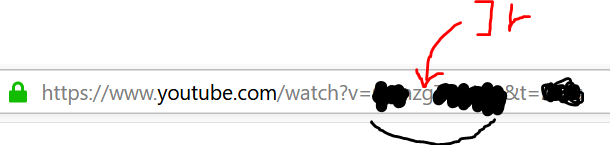

In [4]:
video_id = '5N1r7NAfuqE' #動画ＵＲＬのｖ＝以下。(string after "v=" of video URL)
#                                       ↓実験の結果、マックスが１００でした。１０１不可。(MAX is 100)
test = print_video_comment(video_id, n=100) 

In [20]:
test[:10]

,0,1,2
0,・自動車保険の種類とは？ 00:21\r\n・等級について 03:00\r\n・自動車保険を...,4,0
0,フロントガラスのひび（小石が飛んできた）を車両保険で直したら（保険で直せますよと言われた）、...,11,0
0,次の車は中古にします🎵,9,0
0,自動車保険より自動車に浪費すなってところが共感するわ。,2,0
0,車を買う時に参考にします♪,4,0
0,代理店の女が事故の過失を絶対に認めるな 謝罪するな 頭を下げるなと 煩い事を言っていた。,5,0
0,対人対物は無制限\n会社を見直す\n車両保険は不要,0,0
0,車両保険見直します！,0,0
0,私は募集人ですが、9割は共感できませんでした。\n色々考えがありますからね、保険って難しいですね。,0,0
0,私は車を持ってないし運転しないけど、家族は持ってるし、他人事じゃないですね。\n家と同様、マ...,0,0


## 対象のキーワードを含む動画を再生数順に並べる。  
Arrange videos containing the target keyword in order of the number of plays.

In [38]:
def get_video_info(part, q, order, type, num):
    dic_list = []
    search_response = youtube.search().list(part=part,q=q,order=order,type=type)
    output = youtube.search().list(part=part,q=q,order=order,type=type).execute()

    #一度に5件しか取得できないため何度も繰り返して実行
    for i in range(num):        
        dic_list = dic_list + output['items']
        search_response = youtube.search().list_next(search_response, output)
        output = search_response.execute()

    df = pd.DataFrame(dic_list)
    #各動画毎に一意のvideoIdを取得
    df1 = pd.DataFrame(list(df['id']))['videoId']
    #各動画毎に一意のvideoIdを取得必要な動画情報だけ取得
    df2 = pd.DataFrame(list(df['snippet']))[['channelTitle','publishedAt','channelId','title','description']]
    ddf = pd.concat([df1,df2], axis = 1)

    return ddf

In [44]:
#                                                                              ↓２０×５=１００videos
df = get_video_info(part='snippet',q='生命保険',order='viewCount',type='video',num = 20)

In [ ]:
#videoIdを入力することで、その動画の具体的な再生回数やいいね数を取得する関数を作成
def get_statistics(id):
    statistics = youtube.videos().list(part = 'statistics', id = id).execute()['items'][0]['statistics']
    return statistics

df_static = pd.DataFrame(list(df['videoId'].apply(lambda x : get_statistics(x))))

df_output = pd.concat([df,df_static], axis = 1)

In [46]:
df_output[:3]

,videoId,channelTitle,publishedAt,channelId,title,description,commentCount,dislikeCount,favoriteCount,likeCount,viewCount
0,SfGJm_iA2nA,AXA〈アクサ〉公式チャンネル,2019-11-28T06:45:09.000Z,UCeCGmB_mhtKor48xxLEIQ-Q,WEB限定CM｜ガン治療保険「家族への想い」自分ゴト篇｜アクサ生命保険,アクサの「治療保障」のがん保険 マイ・セラピー もっと見る→https://www.axa....,NaN,7,0,13,6683718
1,Q2BrK24MrFo,東京海上日動あんしん生命/公式チャンネル,2019-07-01T20:24:26.000Z,UCbWuPexnKTStc7D6sMEfk1g,医療保険「ひとりひとりの生きるのそばに」篇【公式/東京海上日動あんしん生命公式ＣＭ】,「おもいっきり生きる人をもっと支えたい」 そんな想いを込め2019年7月にリニューアルした医...,NaN,NaN,0,NaN,5502995
2,WEe9Z0YagOA,mrsmamcat,2011-08-02T11:22:39.000Z,UCuD32SP5UZhAH8ig_N5941w,父親と娘の想いが切ないタイ生命保険のCM（日本語訳付き）,タイ生命保険のCMシリーズ。ドラマ仕立てで好評を得ているシリーズの父娘篇。涙を誘うCMと話題...,336,75,0,4323,993915


# ★Twitter  
how to get the APIkey⇒ https://qiita.com/kngsym2018/items/2524d21455aac111cdee (面倒＆時間がかかる=troublesome)

使えそうな記事（Seems to be usable article）⇒https://www.pytry3g.com/entry/python-twitter-api  
usable article⇒https://qiita.com/kitarikes/items/543ab75a379f0bf903cc

In [73]:
import tweepy
import datetime

#python で Twitter APIを使用するためのConsumerキー、アクセストークン設定(key and token)
Consumer_key = "Your API Key"
Consumer_secret = "Your API Key"
Access_token = "Your API Key"
Access_secret = "Your API Key"

#認証
auth = tweepy.OAuthHandler(Consumer_key, Consumer_secret)
auth.set_access_token(Access_token, Access_secret)
api = tweepy.API(auth, wait_on_rate_limit = True)

## 特定のワードを含むつぶやきを取得＆そのユーザー名も取得  
(Get tweets containing a specific word & get their username)

In [78]:
#                                       ↓keyword!   ↓num of tweets
for tweet in tweepy.Cursor(api.search, q="マスク").items(10):
    if list(tweet.text)[:2] != ['R', 'T']:
       print(tweet.text)
       print(tweet.user.name) 
       print("---------------------------------------------------") 

自分のご両親など高齢の方が居ましたら、マスクや手指消毒、うがいを勧めてください。
インフルエンザで、毎年数万人の方が国内で亡くなっていることを踏まえれば、今回の件を機に対策を始めるのも一つです
russianblue
---------------------------------------------------
とりあえず、自分の分のマスクはあるわけなんだが包装ビニール無しで、直接箱に入ってるマスクってどのくらい放置しといて大丈夫なんだろ？
たしか2年前に買ったやつなんだが・・・ https://t.co/pi0CShBlo4
役牛
---------------------------------------------------
年末に納品していたマスクの中から、昨日今日と使用していただきました。(金銀ハーフ、赤)
使用のタイミングは分かりませんがその他の色もお楽しみに🐉🐉🐉
#dragonlee #ryulee 
#njpw #njnbg 
#プロレス… https://t.co/KKE8ZhWTU0
CADPON☆プロレスマスク製作
---------------------------------------------------
マスクOKになったの嬉しすぎ🥳
みえ
---------------------------------------------------
医療用マスク品薄で納入厳しく、病院や救急現場に困惑と不安　メーカーへの注文、通常の１００倍も #SmartNews 
本当に必要な人の為に…
 https://t.co/KzMCwbMLQj
www.
---------------------------------------------------


## 対象のアカウントのつぶやきを取得する。  
(Get tweets from the target account)

In [ ]:
[tweet.text for tweet in tweepy.Cursor(api.user_timeline, id="TWITTER ID").items(10) if (list(tweet.text)[:2]!=['R', 'T']) & (list(tweet.text)[0]!='@')]

# ★Yahoo API (沢山ある！！) 
ドキュメント⇒https://developer.yahoo.co.jp/sitemap/

In [5]:
app_id = "Your API Key"

## 天気予報API

In [32]:
import urllib
import pprint
import json

APP_ID = app_id

BASE_URL = "http://weather.olp.yahooapis.jp/v1/place"
#　　　　　　　↓豊洲の経度、緯度
COORDINATES = "139.797274,35.654729"
OUTPUT="json"

#単純に自分用のURLを作って、yahooに送っているだけ。
url = BASE_URL + "?appid=%s&coordinates=%s&output=%s" % (APP_ID,COORDINATES,OUTPUT)
#                        ↓指定したURLで、リクエストを送っているだけ。
json_tree = json.loads( urllib.request.urlopen(url).read())

for var in range(0,7):
    date = json_tree['Feature'][0]['Property']['WeatherList']['Weather'][var]['Date']
    date = date[0:4]+"年＿"+date[4:6]+"月"+date[6:8]+"日＿"+date[8:12]+"＿"
    rainfall = json_tree['Feature'][0]['Property']['WeatherList']['Weather'][var]['Rainfall']
    type = json_tree['Feature'][0]['Property']['WeatherList']['Weather'][var]['Type']
    print("%s,%s,%s"%(date,rainfall,type))

2020年＿02月01日＿1650,0.0,observation
2020年＿02月01日＿1700,0.0,forecast
2020年＿02月01日＿1710,0.0,forecast
2020年＿02月01日＿1720,0.0,forecast
2020年＿02月01日＿1730,0.0,forecast
2020年＿02月01日＿1740,0.0,forecast
2020年＿02月01日＿1750,0.0,forecast


## ローカルサーチAPI

In [49]:
#豊洲周辺の禁煙のホテルカフェを出力する。
import json
import socket
import urllib.error
import urllib.request

# ローカルサーチクラス
class LocalSearch:

    def __init__(self, appid):
        self.appid = appid

    def search(self, query):
        baseurl = 'https://map.yahooapis.jp/search/local/V1/localSearch'
        #ここに、好きなパラメータを指定する！！！！！
        params = {
            'query': query,
            'gc': '0115',#←グルメ・カフェ
            'lat':'35.654729',#（豊洲の）緯度
            'lon':'139.797274',#（豊洲の）経度
            'smoking':'1',#禁煙
            'output': 'json',
            'results': '10',
            'sort': 'score',
        }
        url = '{}?{}'.format(baseurl, urllib.parse.urlencode(params))
        headers = {
            'User-Agent': 'Yahoo AppID: {0}'.format(self.appid),
        }
        req = urllib.request.Request(url, headers=headers)
        with urllib.request.urlopen(req, timeout=3) as res:
            body = res.read()
            return self.__json2pois(body)

    def __json2pois(self, data):
        ydf = json.loads(data)
        features = ydf['Feature']
        result = []
        for f in features:
            if f['Geometry']['Type'] == 'point':
                ll = f['Geometry']['Coordinates'].split(',')
                poi = {'name':f['Name'], 'lat': ll[1], 'lon': ll[0]}
                result.append(poi)
        return result

try:            
    appid = app_id # アプリケーションIDを指定
    query = 'ホテル' 
    #
    pois = LocalSearch(appid).search(query)
    for poi in pois:
        print(poi['name'])
        print(' {lat}, {lon}'.format(lat=poi['lat'], lon=poi['lon']))
        print()
except socket.timeout as err:
    print('timeout: {0}'.format(err))
except urllib.error.URLError as err:
    print('URLError: {0}'.format(err))
except Exception as err:
    print('Exception: {0}'.format(err))

ラウンジ ・クオーレ／ホテルトラスティ 東京ベイサイド
 35.628716, 139.78720

ザ・ロビーラウンジ／シャングリ・ラ ホテル 東京
 35.6825835, 139.769375

カフェ＆バーラウンジ クオーレ／ホテルトラスティプレミア日本橋浜町
 35.6872131, 139.787412

ラウンジ オアシス／コートヤード・マリオット 銀座東武ホテル
 35.6683684, 139.764931

ラウンジ21／第一ホテル東京 最上階（21階）
 35.6686981, 139.757532

ロビーラウンジ フォンテーヌ／ロイヤルパークホテル
 35.6823040, 139.786662

ロビーラウンジ クリスタルムーブメント／東武ホテルレバント東京
 35.697258, 139.81072



# ★国土地理院API（申請不要）

In [54]:
import requests

lat = 35.654729  # 緯度
lon = 139.797274 # 経度

url = "http://cyberjapandata2.gsi.go.jp/general/dem/scripts/getelevation.php" \
       "?lon=%s&lat=%s&outtype=%s" %(lon, lat, "JSON")

resp = requests.get(url, timeout=10)
data = resp.json()

#標高を出力する。
print(data["elevation"])

2


# ★楽天API（色々ある）  
ドキュメント⇒https://webservice.rakuten.co.jp/document/

In [55]:
app_id = "Your API Key"

## 予約受付中の新書の内、人気の高い本を選出（結構面白い）

In [71]:
#ライブラリをインポート
import requests
import json

#アプリID指定
appID = app_id

#パラメタ指定
payload = {
    'applicationId': app_id,
    'keyword': 'Python',
    'hits': 10,
    'size':3,
    'availability':5,
    'sort': 'sales',
    }
 
#APIの雛型
url = "https://app.rakuten.co.jp/services/api/BooksBook/Search/20170404"

r = requests.get(url, params=payload) 
resp = r.json()

print("num of kensaku =",resp['count'])
print('-'*40)
 
for i in resp['Items']:
    item = i['Item']['title']
    print(item)

num of kensaku = 249
----------------------------------------
異端のすすめ　強みを武器にする生き方
カメの甲羅はあばら骨
狐の婿取りー神様、進言するの巻ー
世界哲学史2
戦国姫 - 51人のお姫さま大図鑑 -
四つ子ぐらし（5）上 初恋の人の正体
小説 映画ドラえもん のび太の新恐竜
指輪の選んだ婚約者
蒼洋の城塞4
魔界都市ブルース　闇鬼刃


## 周辺の宿を検索します！

In [116]:
#ライブラリをインポート
import requests
import json

#アプリID指定
appID = app_id

#パラメタ指定
payload = {
    'applicationId': app_id,
    'latitude':35.654729,
    'longitude':139.797274,
    'format':'json',
    'searchRadius': '3',
    'datumType': '1',
    'hits': '5'
    }
 
#APIの雛型
url = "https://app.rakuten.co.jp/services/api/Travel/SimpleHotelSearch/20170426"

r = requests.get(url, params=payload) 
resp = r.json()

for hs in resp['hotels']:
    print(hs['hotel'][0]['hotelBasicInfo']['hotelName'])
    print(hs['hotel'][0]['hotelBasicInfo']['address2'])
    print(hs['hotel'][0]['hotelBasicInfo']['access'])
    print(hs['hotel'][0]['hotelBasicInfo']['userReview'])
    print('------------------------------------------------------------------------------------------------------------')

ホテルリブマックス豊洲駅前
江東区豊洲5-5-34
東京メトロ有楽町線／ゆりかもめ　豊洲駅より徒歩にて約２分
ぐっすり眠れ待ち合わせの時間まで爆睡でした。きれいで良かったです。　2020-01-23 23:11:09投稿
---------------------------------------------------------------------------------
三井ガーデンホテル豊洲ベイサイドクロス（２０２０年６月２５日オープン）
江東区豊洲2-2-1
東京メトロ有楽町線 豊洲駅 直結
None
---------------------------------------------------------------------------------
ｈｏｔｅｌ　ＭＯＮｄａｙ　豊洲
江東区東雲1-2-11
豊洲駅より徒歩にて約7分　各交通機関からのアクセスはHPをご参照下さい。
tokyoビックサイトから近くて便利です。東雲駅から真っ直ぐ1本道で来れるのでホテルまで迷うこともありません。夕飯をどこかで食べようとしたら牛丼屋くらいしかないのでゆっくり外食したい方はビックサイト近…　2020-01-21 14:58:00投稿 <a href="http://img.travel.rakuten.co.jp/image/tr/api/hs/RmfmX/?f_hotel_no=168492" class="3click">つづきはこちら</a>
---------------------------------------------------------------------------------
Ｒｙｏｋａｎ　結々　Ｔｏｋｙｏ（２０１９年１０月１３日オープン）
江東区塩浜1-5-18
有楽町線　豊洲駅より徒歩にて約１０分
None
---------------------------------------------------------------------------------
ホテルＪＡＬシティ東京　豊洲（２０１９年１２月９日オープン）
江東区豊洲6-4-20
ゆりかもめ線　市場前駅より徒歩にて約２分
駅から近いし、建物の中にコンビニがあったのがとても便利で良かったです。できたばかりなので、部屋もとても綺麗でした。ディズ

# リクルート（サービス終了多い）  
ドキュメント⇒https://webservice.recruit.co.jp/carsensor/

In [ ]:
リクルートのID
aaaaaaaaaaa